# Estimating matchup percentages in a hierarchical model with Stan

Following up on my previous post, I will be estimating winning percentages between decks in the game of Magic. First, I will give some motivation and the main part is a Bayesian hierarchical model written in [Stan](mc-stan.org), using its Python interface, `pystan`. First, let's load the data and the dependencies. 

In [1]:
import pystan
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
mu = pd.read_csv("./data/matchups_clean.csv", index_col=0).rename(columns = dict(over="vs"))
all_decks = list(set(mu.deck.values.tolist() + mu.vs.values.tolist()))

# the categorical datatype is appropriate, and it helps in converting to stan's data format
mu.deck = pd.Categorical(mu.deck, categories=all_decks)
mu.vs = pd.Categorical(mu.vs, categories=all_decks)

np.random.seed(1)

mu.sample(10)

,deck,vs,won,lost
121,Burn,Infect,3,1
51,Burn,Hardened Scales,5,6
62,Hardened Scales,Izzet Phoenix,9,6
59,Izzet Phoenix,Spirits,20,12
120,Green Tron,Infect,7,8
95,Humans,Jund,4,0
98,Hardened Scales,Humans,8,3
91,Ironworks,Jund,6,5
118,Infect,Ironworks,6,2
61,Green Tron,Izzet Phoenix,10,8


The data that I'll be using is collected from [this](https://www.channelfireball.com/articles/the-ghosts-of-portland-massive-modern-matchup-analysis/) post. In Magic, you are free to build your own deck of 60 cards that you bring to a tournament. Virtually all players select a deck that is a close variation of a well-known _archetype_. These archetypes work well against some other ones, and don't work well in other cases. This leads to a bit of a probabilistic rock-paper-scissors situation if you will. Usually there is not a single best deck, but if you expect some archetype to show up a lot, you want to chose a different archetype that matches up well against it. But the winning percentages are not a given. There is not a lot of data collection on this, and the creators of the game are actively avoiding publishing good information on the matchups, to keep it interesting. So I have to work with limited data, but make the most of it. Exactly where I want to be. 

In the table above, you can see some unclear matchups, and some matchups that look bad for one side, for example, between the _Humans_ and _Jund_ archetypes. In that case, the _Humans_ archetype won all of the four encounters. Let's directly estimate the winning percentage from the outcomes above. 

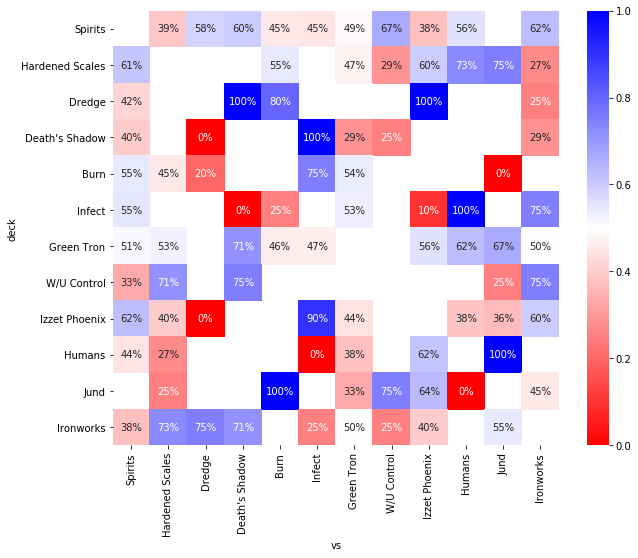

In [3]:
opp = mu.rename(columns = dict(deck="vs", vs="deck", lost="won", won="lost"))
symm = pd.concat([mu, opp], sort=False).set_index(['deck', 'vs'])
naive_perc = (symm.won / (symm.won + symm.lost)).unstack(1)
plt.figure(figsize=(10, 8))
sns.heatmap(naive_perc, annot=True, fmt=".0%", cmap=plt.get_cmap("bwr_r"));

This doesn't look good, and this problem is very common when you have little data. Or at least when your model has a lot of parameters relative to the data. 

There are parameters that you have no data on at all. Similarly, the parameters that you do have data on are exaggerated. No matchup is going to be 0% or 100%. What is the matchup between _Izzet Phoenix_ and _W/U Control_ like? I encounter this situation often at work, and it is common to say "we need more data" and simply move on.  But if you think about this, you could actually derive reasonable estimates for the missing matchups. For example, by saying, this deck is doing well against all other decks, so I'm going to guess it's 60%. Or, more advanced, the matchup versus Burn is similar to the matchup against Izzet Phoenix, so I'm going to go for something close to that matchup that I actually do have some data on. In the model that will follow, I will use a statistics that implement this latter line of reasoning. The crucial twist that hierarchical models add is that they are actually simultaneously estimating the similarity of matchups, so I don't have to tell the model in advance that the _Burn_ matchup is a bit like the _Izzet Phoenix_ matchup. That makes sense, because that information is in the data as well, but still, I find it kind of amazing. 

Here is the model, with annotations if you want to understand a bit more deeply what's going on. 

In [4]:
%%time

model_code = '''
data {

    /*
    the data should contain one record per matchup, you might want to include both burn vs infect 
    as well as infect vs burn, which works fine, but it's interpreted by the model as twice the information
    /**/

    int N; // number of decks
    int M; // number of recorded matchups
    
    int deck[M]; // index of deck
    int vs[M];   // index of the opposite deck
    
    int won[M];  // number of times the first deck won
    int n[M];    // out of n recorded matches for this matchup
}

parameters {

  vector[N] A[N]; // N vectors of lenght N for all matchups. symmetry is handled later
  
  real deck_pow_sd; // all decks have a raw power level
  real deck_pow[N]; // and their prior is pooled
  
  real deck_var_mu; // all decks have a variance in power across matchups 
  real deck_var_sd; // this is also pooled
  vector[N] deck_var;
  
  corr_matrix[N] O; // this is the matrix that encodes information on similarity between matchups

}

model {
  
  // i use some unnecessary vars to simplify the coding
  int a;
  int b;
  real p;
  
  // the hierarchical priors for variance and power level
  deck_pow_sd ~ gamma(2, 2);
  deck_pow ~ normal(0, deck_pow_sd);
  
  deck_var_mu ~ normal(0, 1);
  deck_var_sd ~ gamma(2, 2);
  deck_var ~ normal(deck_var_mu, deck_var_sd);
  
  // the covariance matrix with a customary lkj 2 prior
  O ~ lkj_corr(2);
  for(i in 1:N)
      A[i] ~ multi_normal(exp(deck_var), O);
  
  
  // the matchups are the real information
  for(i in 1:M){
      
      a = deck[i];
      b = vs[i];
      
      // this next line handles the (anti-)symmetry in the matchup matrix
      // it works, but there might be a better way
      // the coefficients in a should be doubled for interpretation
      
      p = deck_pow[a] - deck_pow[b] + A[a, b] - A[b, a];
      
      // at the core, this is still a binomial model
      won[i] ~ binomial_logit(n[i], p);
      
  }

}

generated quantities {

  // for each sample, i calculate the resulting matchup table as well
  // the sampler is complaining that the diagonal is unused but it makes the coding a lot easier
  // so i'll just ignore that

  real mu[N, N];
  
  for(i in 1:N){
      mu[i, i] = 0;
      for(j in (i+1):N){
          mu[i, j] = deck_pow[i] - deck_pow[j] + A[i, j] * exp(deck_var[i]) - A[j, i] * exp(deck_var[j]);
          mu[j, i] = - mu[i, j];
      }
  }
  
  mu = inv_logit(mu);
  
}

'''

sm = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a42892281e798b6f383b477edb0346a4 NOW.
/home/gijs/anaconda3/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmpik4i1rsc/stanfit4anon_model_a42892281e798b6f383b477edb0346a4_4735557782649503983.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


CPU times: user 1.5 s, sys: 134 ms, total: 1.63 s
Wall time: 1min 36s


In human language, there are a couple of elements to this model, 

* Each deck has a basic power level
* Each deck has some variance between the matchups, some decks may perform matchup dependent, others could be more stable
* There is a relation between matchups, so decks that do well against a specific deck, also do well together against another specific deck

The data is already clean and the conversion is easy. Stan does use one-based indexing. 

In [5]:
%%time

data = {
    "N": len(all_decks),
    "M": mu.shape[0],
    "deck": mu.deck.cat.codes.values + 1,
    "vs": mu.vs.cat.codes.values + 1,
    "won": mu.won.values,
    "n": (mu.lost + mu.won).values
}

fit = sm.sampling(data=data, n_jobs=1)

CPU times: user 5min 17s, sys: 1.38 s, total: 5min 19s
Wall time: 5min 18s


The sampling is fast enough. There is a lot of complaining on the diagonal entries in the matchup table, which are unused actually. So those warnings are expected, but I will ignore them. 

Below you find the new estimates for all the matchups. I'm not an expert at all on this, but these estimates look good to me. I should really do some predictive checks, but I'll save the `loo` estimates for another post. 

Thanks to the Stan sampler, I can show uncertainty estimates for all parameters. These are the 80% credibility intervals. This is really where the Bayesian approach shines I think, allowing us to work with little data (relative to the complexity of the model), and dealing with the uncertainty all the way. Most of the matchups are still quite uncertain, reflecting the fact that we do, indeed, do not have a lot of data. 

<Figure size 864x720 with 0 Axes>

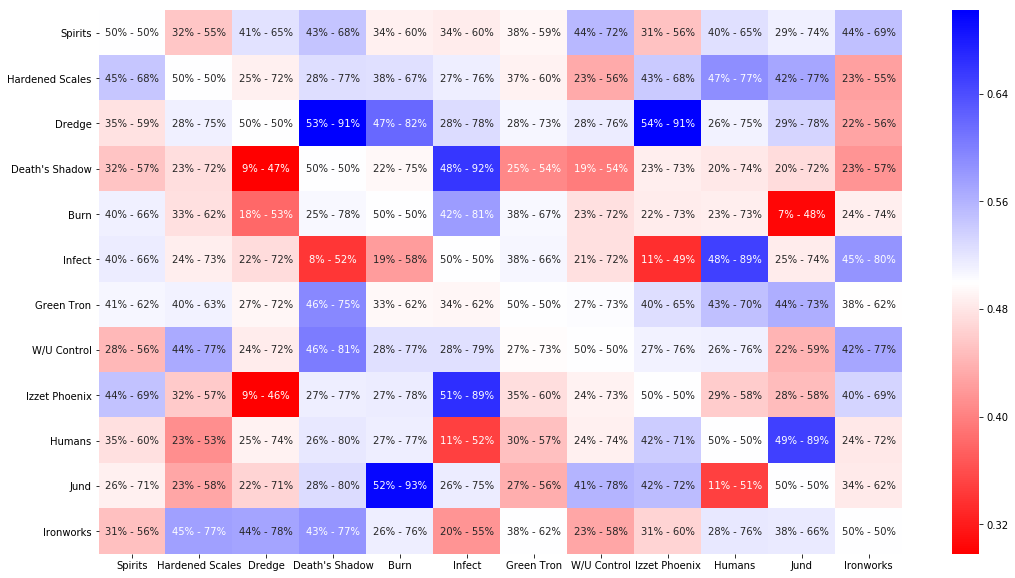

In [6]:
matchups = fit.extract()['mu']
mup = pd.DataFrame(np.median(matchups, axis=0), index=all_decks, columns=all_decks)
plt.figure(figsize=(12, 10))
lower = np.quantile(matchups, .1, axis=0).ravel().tolist()
upper = np.quantile(matchups, .9, axis=0).ravel().tolist()
annot = [f"{l:.0%} - {u:.0%}" for l, u in zip(lower, upper)]
annot = np.array(annot).reshape(len(all_decks), -1)
plt.figure(figsize=(18, 10))
sns.heatmap(mup, annot=annot, fmt="", cmap=plt.get_cmap("bwr_r"));

You can compare the naive estimation with the above below. All estimates are pulled towards 50%. In the left image, attention is drawn towards the extreme values, but then I find myself asking all the time, on how many matchups is this data based? On the right, the extreme cases are the ones we know from the data to be extreme. The effect of the correlation between matchups is not very big, with all matchups without any data estimated to be somewhere between 48% and 52%. Here, I have shown the median estimate instead of the interval. 

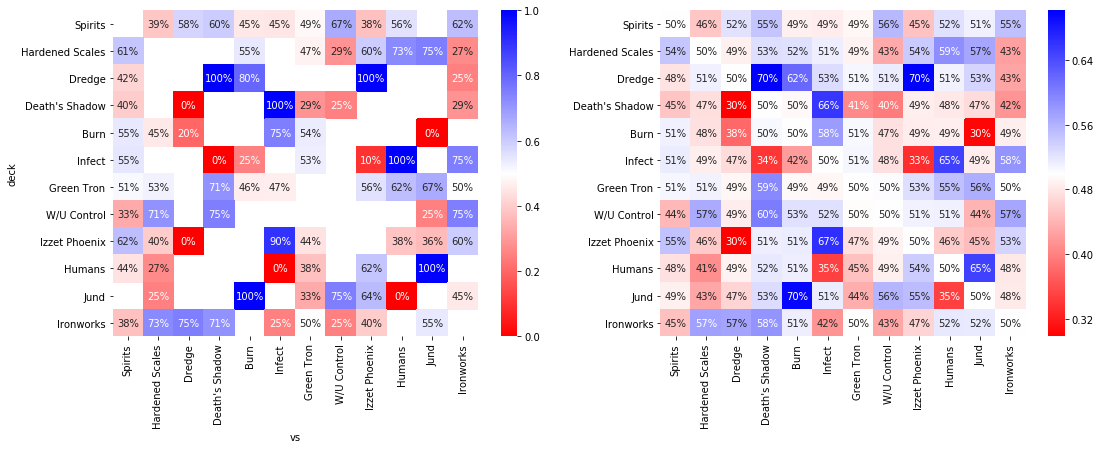

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
sns.heatmap(naive_perc, annot=True, fmt=".0%", cmap=plt.get_cmap("bwr_r"), ax=axes[0]);
sns.heatmap(mup, annot=True, fmt=".0%", cmap=plt.get_cmap("bwr_r"), ax=axes[1]);

To round up this post, some plots of the other parameters in the model. First of, the covariances between the matchups. 

* Deck's that perform well against Death's Shadow, also work well against Izzet Phoenix. Conversely, decks that perform poorly against one of these tend to do bad against both. 
* Negative correlations also show up, for example, decks that do well against Dredge perform poorly against Infect, and vice-versa. 

These are some interesting observations, but, for the moment, they are not that impactful for the final estimates of the matchups above. The uncertainty around these estimates (shown as an interval) is big, also including opposite signs at 80% credibility. It is hard to interpret the numbers, and I have in fact multiplied these by 10 to increase readibility. 

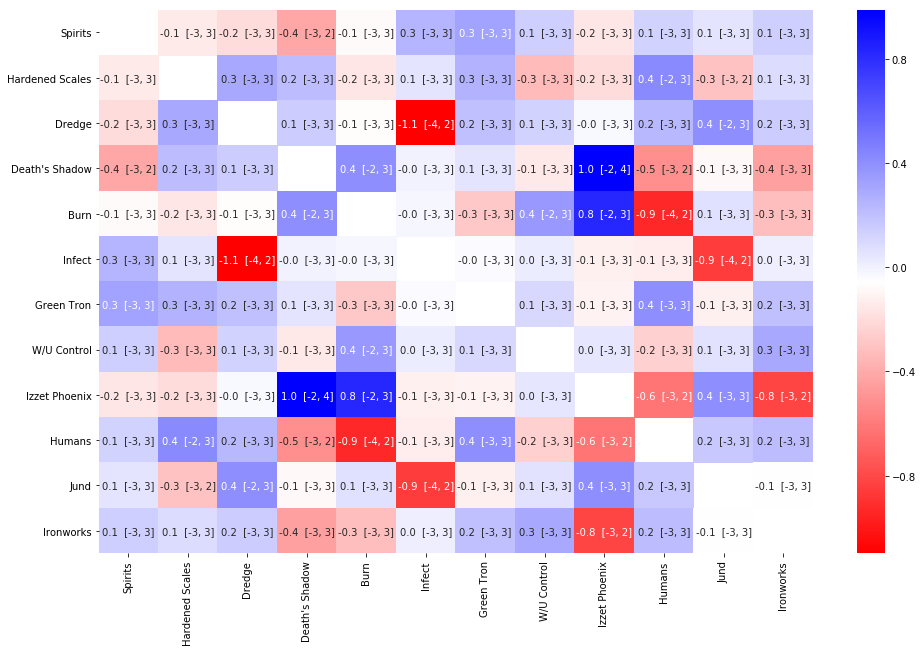

In [8]:
cov = fit.extract()['O'] * 10

lower = np.quantile(cov, .1, axis=0).ravel().tolist()
upper = np.quantile(cov, .9, axis=0).ravel().tolist()
med = np.median(cov, axis=0).ravel().tolist()
annot = [f"{m:.1f}  [{int(l)}, {int(u)}]" for m, l, u in zip(med, lower, upper)]
annot = np.array(annot).reshape(len(all_decks), -1)

cov_med = np.median(cov, axis=0)
np.fill_diagonal(cov_med, np.nan)

cov_df = pd.DataFrame(cov_med, index=all_decks, columns=all_decks)

plt.figure(figsize=(16, 10))
sns.heatmap(cov_df, annot=annot, fmt="", cmap=plt.get_cmap("bwr_r"));

The power level differences are also not big relative to the differences between the decks.

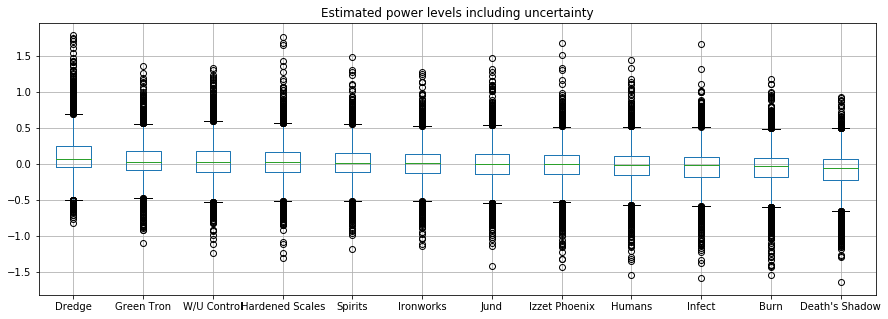

In [9]:
deck_pow = pd.DataFrame(fit.extract()['deck_pow'], columns=all_decks)
order = deck_pow.median(axis="rows").sort_values(ascending=False)
deck_pow.reindex(order.index, axis="columns").boxplot(figsize=(15, 5))
plt.title("Estimated power levels including uncertainty");

The variances for all the decks are almost in the same order of the power levels. This is actually a bit suspicious. It may indicate some bad parametrization in the model, that should be investigated more. 

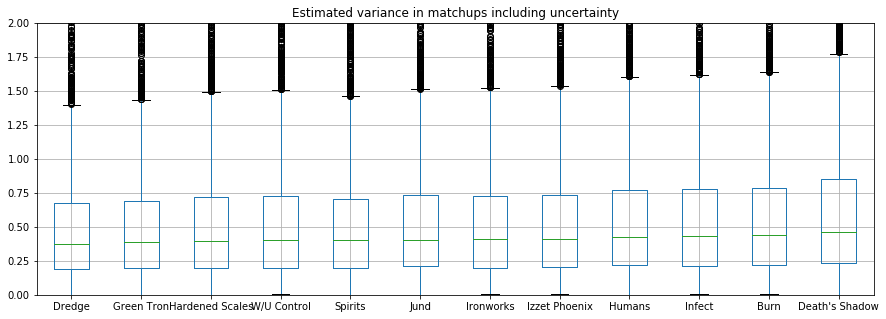

In [10]:
deck_var = pd.DataFrame(np.exp(fit.extract()['deck_var']), columns=all_decks)
order = deck_var.median(axis="rows").sort_values()
deck_var.reindex(order.index, axis="columns").boxplot(figsize=(15, 5))
plt.ylim((0, 2))
plt.title("Estimated variance in matchups including uncertainty");

## Conclusion

I have shown you a model, for estimating matchup percentages accross decks with limited data. There's more work to do from here, as there always is. I think, from my limited knowledge of the game, that the model could be improved by including player strengths. This is a competitive game of course, so a matchup isn't decided by the decks alone. It could be interesting to look for some conclusions of the skill vs. luck ratio in this game, perhaps even for specific matchups. Sideboarding effects, for those that know the game, are also interesting, and to learn about those it would be helpful to have not just the outcome of the whole match, but also of the underlying games (a match consists of three separate games, after the first of which you are allowed to change your deck a bit to tune for the matchup). 

My previous post was about simulating metagames based on matchups percentages, so in a follow-up, I'd like to combine these analyses into a prediction on the metagame shifts. One of the archetypes, _Ironworks_, is now actually banned from the game and it would be interesting to see how that will affect those predictions as well. 